In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

In [5]:
train_transaction = pd.read_csv('C:/Users/Admin/Desktop/Anti-fraud-Classification/train.csv')
test_transaction = pd.read_csv('C:/Users/Admin/Desktop/Anti-fraud-Classification/test.csv')

# Разведочный анализ

Датасет содержит описание транзакций с подробнобной информацией о времени операции, торговой точке, категории покупки, сумме, плательщике (имя, пол, адрес, профессия) и геолокации (координаты покупателя и продавца).

Задача: **выявление мошеннических транзакций** --> антифрод-аналитика.

Проблема детекции фрода сложна тем, что мошеннические действия часто маскируются под нормальное поведение, что приводит к сильному дисбалансу классов и требует учета большого количества признаков.

In [6]:
test_transaction.head()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon
0,2019-09-14 02:46,"fraud_Stokes, Christiansen and Sipes",grocery_net,25.79,Michael,Rodriguez,M,172 Paula Inlet Apt. 650,Cross Plains,TX,76443,32.1482,-99.1872,1897,Chief Operating Officer,31.772057,-99.103183
1,2019-07-25 20:30,fraud_Thompson-Gleason,health_fitness,87.80,Curtis,Young,M,4319 Watson Shoals Suite 658,Falconer,NY,14733,42.1239,-79.1895,3833,Metallurgist,42.635312,-78.334559
2,2020-01-05 17:27,fraud_Friesen Inc,shopping_pos,10.98,Brandy,Quinn,F,9734 Beard Fields Suite 885,Altair,TX,77412,29.6047,-96.5249,106,"Editor, film/video",29.363782,-95.624994
3,2019-07-21 00:14,"fraud_Jenkins, Hauck and Friesen",gas_transport,71.97,Ashley,Mcdonald,F,3160 Tina Estates Suite 234,Marietta,SC,29661,35.0296,-82.5136,5648,Museum/gallery exhibitions officer,35.142659,-82.489028
4,2019-03-13 00:45,"fraud_Kovacek, Dibbert and Ondricka",grocery_pos,210.50,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,32.2768,-95.3031,144160,Sports development officer,31.833016,-94.746542


In [7]:
train_transaction.tail()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
786426,2019-04-10 12:35,"fraud_O'Connell, Botsford and Hand",home,76.56,Ryan,Foster,M,03921 Cole Mission Suite 882,Hampton,FL,32044,29.8575,-82.1483,2060,Oncologist,29.235257,-82.407844,0
786427,2019-12-15 09:34,"fraud_Adams, Kovacek and Kuhlman",grocery_net,68.58,Jim,Johnson,M,868 Brady Mill Apt. 837,Gretna,LA,70056,29.8872,-90.0331,55581,Biomedical scientist,29.015274,-90.564712,0
786428,2019-10-12 10:22,"fraud_Lind, Huel and McClure",gas_transport,66.66,Christopher,Horn,M,956 Sanchez Highway,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,37.515508,-82.443788,0
786429,2019-10-18 09:01,fraud_Rempel PLC,grocery_net,38.06,Samuel,Sandoval,M,0005 Morrison Land,Mounds,OK,74047,35.8896,-96.0887,7163,Fitness centre manager,35.203864,-96.999902,0
786430,2019-10-10 16:51,"fraud_Medhurst, Cartwright and Ebert",personal_care,148.36,Christopher,Johnson,M,28711 Kristine Junction Suite 309,Greenville,OH,45331,40.0987,-84.6342,22930,Media planner,39.112400,-84.456052,0


In [8]:
train_transaction['target'].value_counts()

target
0    781927
1      4504
Name: count, dtype: int64

In [3]:
legit_transaction = train_transaction[train_transaction['target'] == 0]
fraud_transaction = train_transaction[train_transaction['target'] == 1]

NameError: name 'train_transaction' is not defined

C:\Users\Admin\AppData\Local\Temp\ipykernel_9672\2305282408.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_9672\2305282408.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Обычные (0)', 'Мошенничество (1)'], fontsize=12)


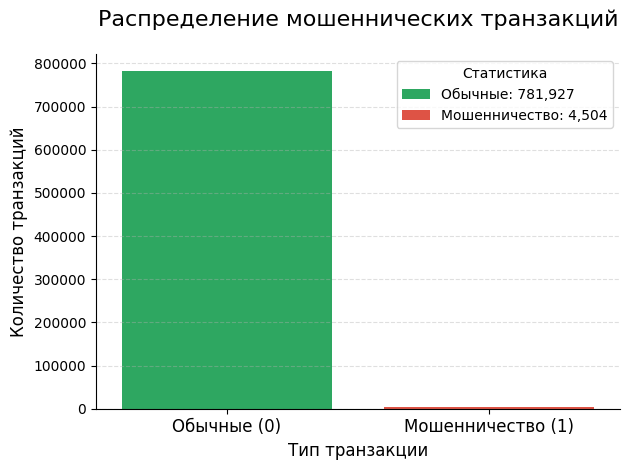

In [10]:
ax = sns.countplot(
    x='target',
    data=train_transaction,
    palette={'0': '#27ae60', '1': '#e74c3c'},
    linewidth=1.2,
    saturation=0.9
)
plt.title('Распределение мошеннических транзакций', fontsize=16, pad=20)
plt.xlabel('Тип транзакции', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
ax.set_xticklabels(['Обычные (0)', 'Мошенничество (1)'], fontsize=12)

plt.legend(
    labels=[f'Обычные: {train_transaction["target"].value_counts()[0]:,}',
            f'Мошенничество: {train_transaction["target"].value_counts()[1]:,}'],
    title='Статистика',
    loc='upper right'
)

plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()

plt.tight_layout()
plt.show()

In [11]:
train_transaction.head()

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0
3,2019-05-13 16:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.3833,-95.0619,43,"Engineer, production",30.888406,-95.141609,0
4,2019-08-18 07:27,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),39.376017,-121.311691,0


In [12]:
test_transaction.nunique()

transaction_time    206241
merch                  693
cat_id                  14
amount               29301
name_1                 347
name_2                 478
gender                   2
street                 960
one_city               876
us_state                51
post_code              947
lat                    945
lon                    946
population_city        862
jobs                   492
merchant_lat        260067
merchant_lon        261280
dtype: int64

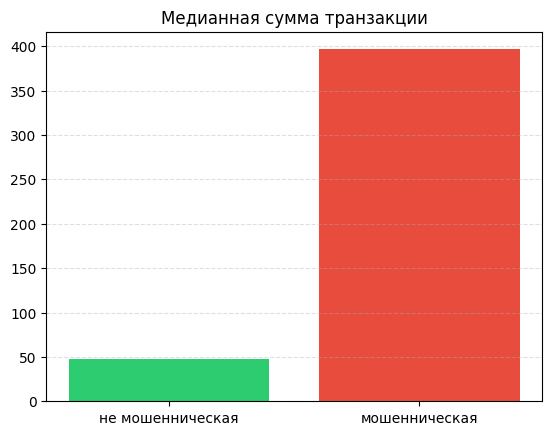

In [13]:
plt.bar('не мошенническая', legit_transaction['amount'].median(), color='#2ecc71')
plt.bar('мошенническая', fraud_transaction['amount'].median(), color='#e74c3c')
plt.title('Медианная сумма транзакции')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [14]:
numeric_features = train_transaction.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_transaction[numeric_features].corr()

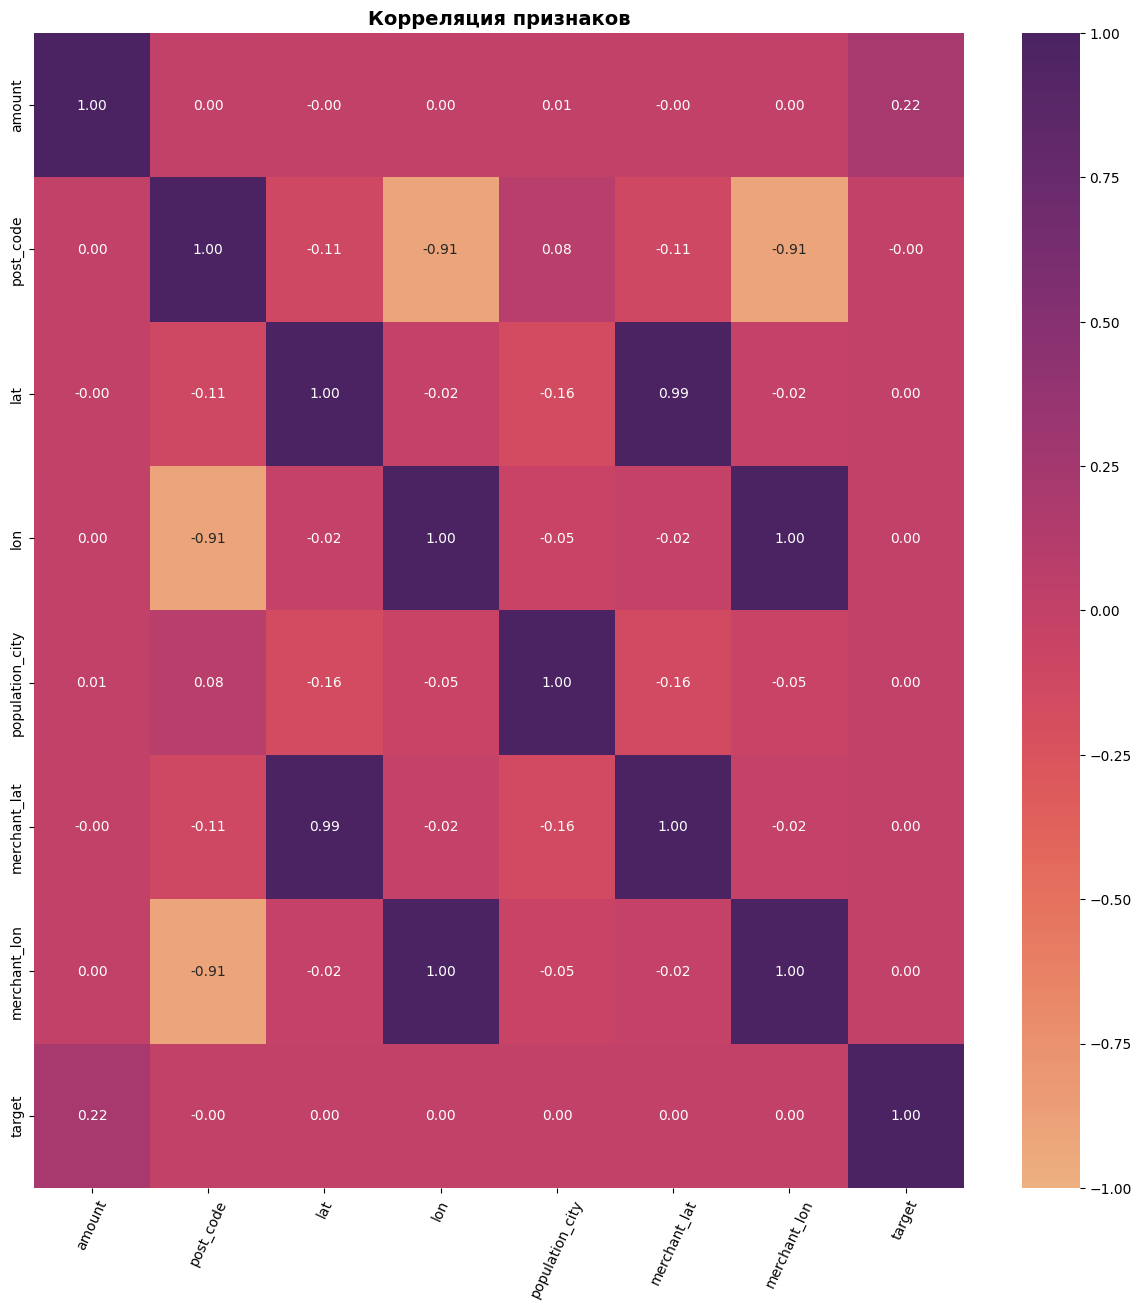

In [15]:
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='flare', fmt=".2f", vmin=-1, vmax=1)
plt.title('Корреляция признаков', fontweight='bold', fontsize=14)
plt.xticks(rotation=65)
plt.show()

Видно, что большинство признаков слабо коррелируют друг с другом и с целевой переменной target. Выделяются сильные корреляции между lat и merchant_lat (0.99), между lon и merchant_lon (1.00), что логично — признаки отражают географическую близость между пользователем и торговой точкой. Также наблюдается сильная отрицательная корреляция между post_code и lon / merchant_lon (-0.91), что может объясняться географической логикой индексов. Признак amount слабо коррелирует с target (0.22).

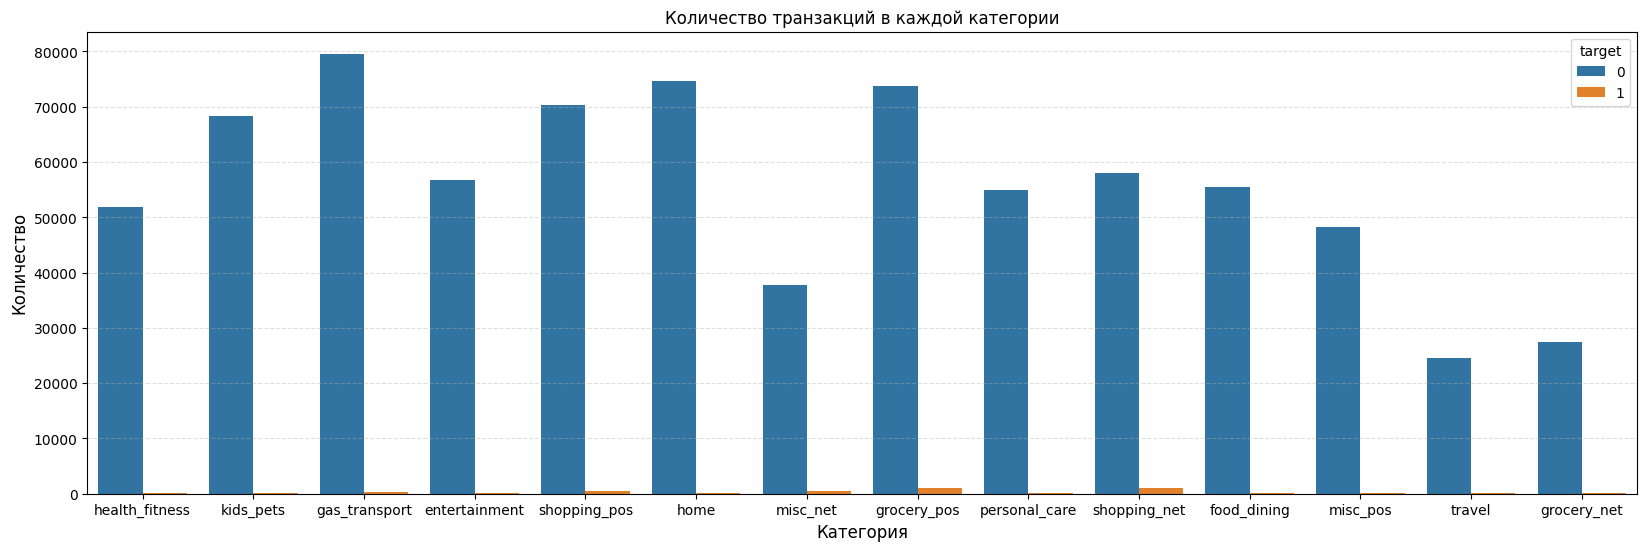

In [16]:
plt.figure(figsize=(20, 6))
plt.title('Количество транзакций в каждой категории')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество', fontsize=12)
sns.countplot(x='cat_id', hue='target', data=train_transaction)
plt.show()

<Axes: title={'center': 'Сумма единичной транзакции в каждой категории (мошеннические)'}, xlabel='Категория', ylabel='Количество транзакций'>

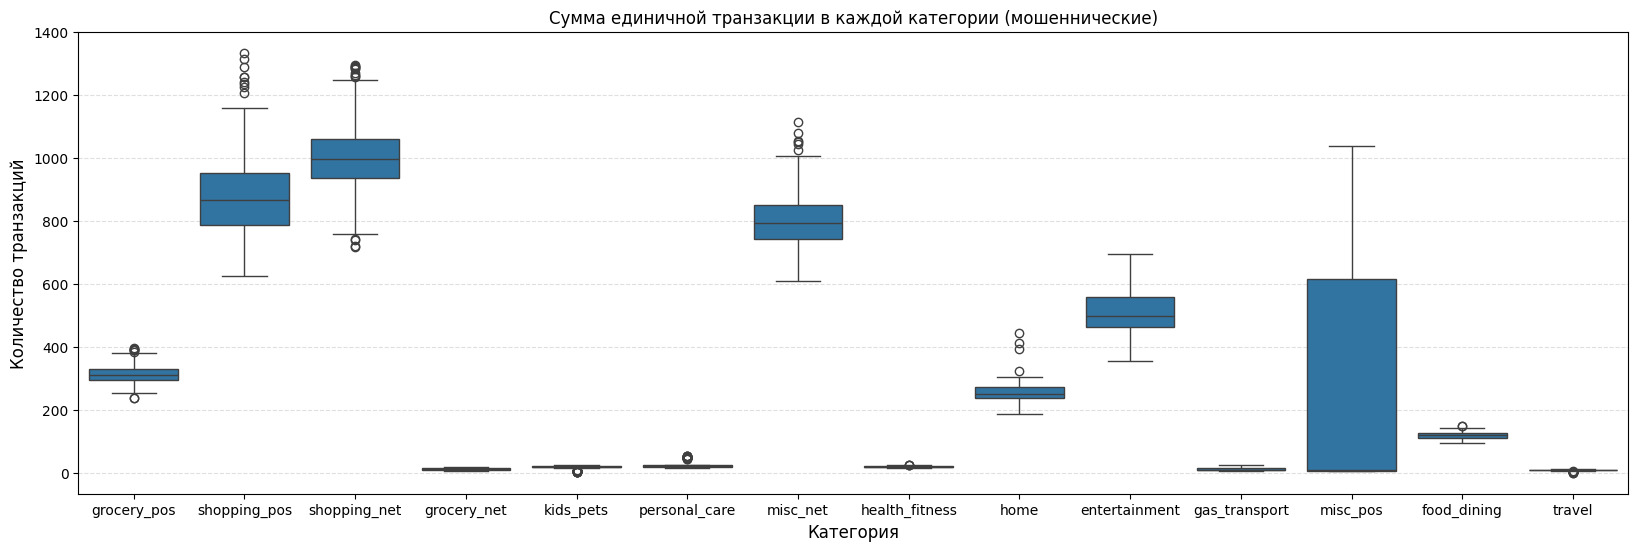

In [17]:
plt.figure(figsize=(20, 6))
plt.title('Сумма единичной транзакции в каждой категории (мошеннические)')
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.boxplot(x='cat_id', y='amount', data=fraud_transaction)

<Axes: title={'center': 'Сумма единичной транзакции в каждой категории (не мошеннические)'}, xlabel='Категория', ylabel='Количество транзакций'>

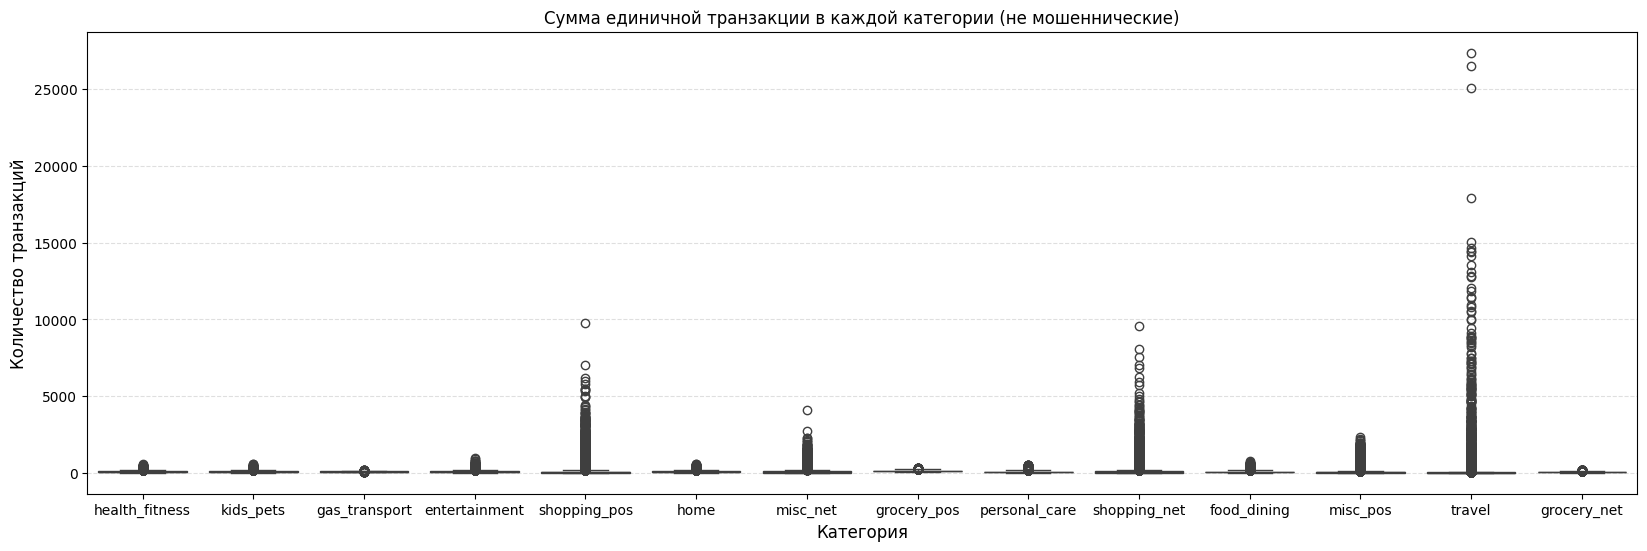

In [18]:
plt.figure(figsize=(20, 6))
plt.title('Сумма единичной транзакции в каждой категории (не мошеннические)')
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.boxplot(x='cat_id', y='amount', data=legit_transaction)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9672\1568222115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cat_id', data=fraud_transaction, palette='viridis',)


<Axes: title={'center': 'Количество транзакций в каждой категории (мошеннические)'}, xlabel='Категория', ylabel='Количество транзакций'>

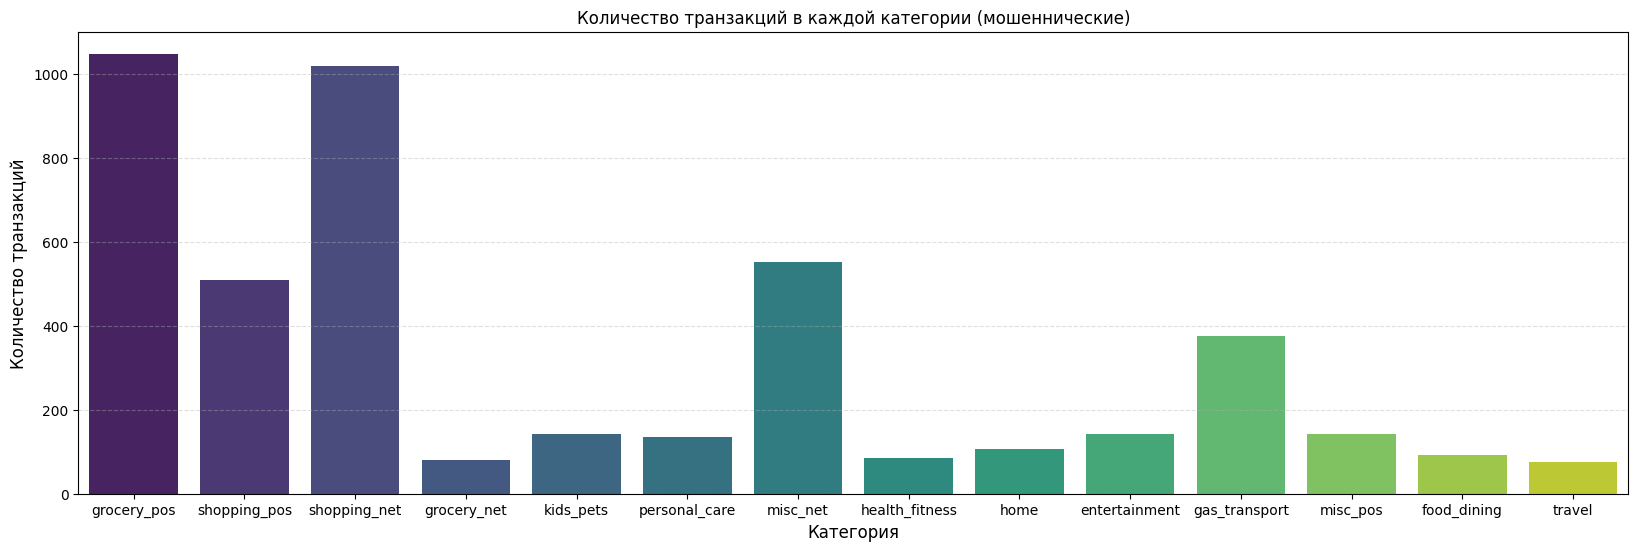

In [19]:
plt.figure(figsize=(20, 6))
plt.title('Количество транзакций в каждой категории (мошеннические)')
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.countplot(x='cat_id', data=fraud_transaction, palette='viridis',)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9672\3689852142.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


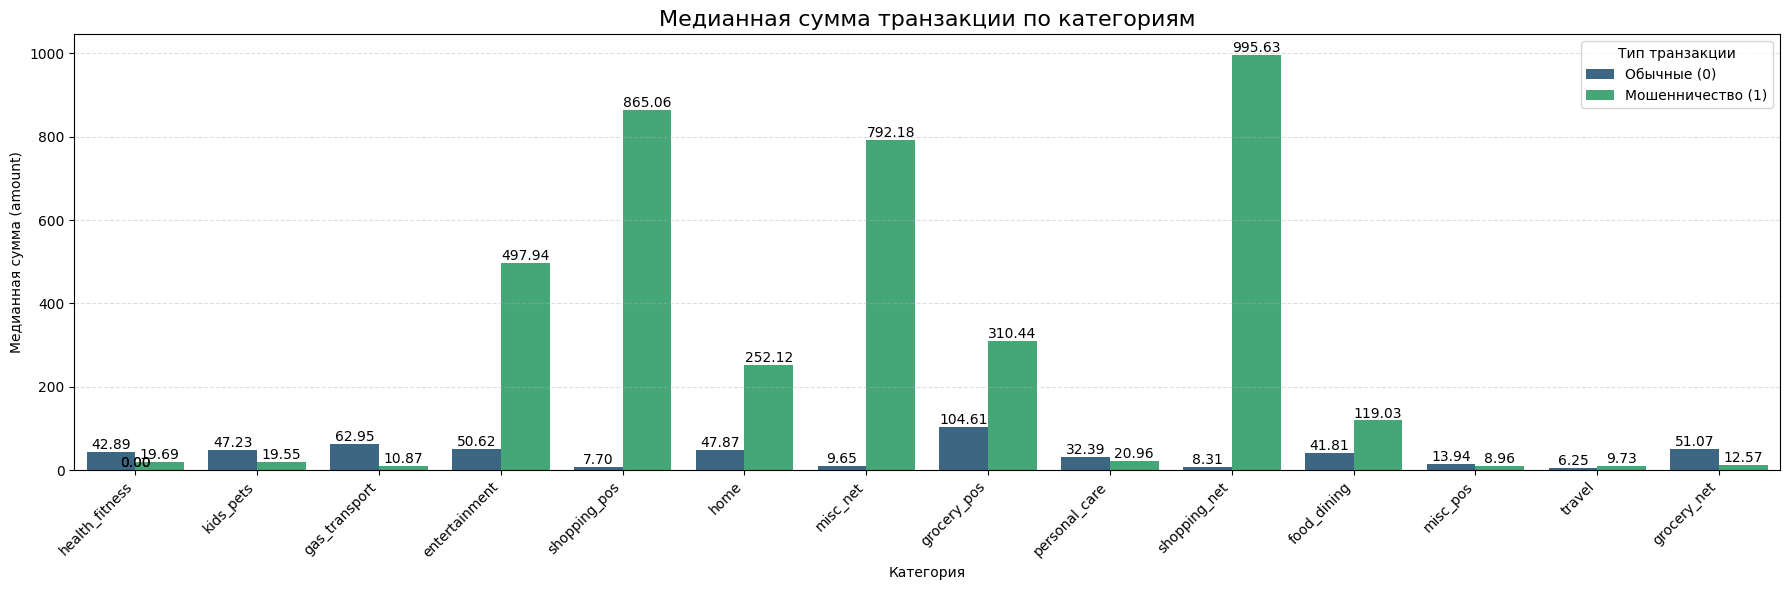

In [21]:
plt.figure(figsize=(18, 6))
sns.barplot(
    x='cat_id',
    y='amount',
    hue='target',
    data=train_transaction,
    estimator='median',
    ci=None,
    palette='viridis'
)

plt.title('Медианная сумма транзакции по категориям', fontsize=16)
plt.xlabel('Категория')
plt.ylabel('Медианная сумма (amount)')
plt.legend(title='Тип транзакции', labels=['Обычные (0)', 'Мошенничество (1)'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

Видно, что медианная сумма транзакции и количество мошеннических транзакций коррелирует между собой. За исключением категории grosery_pos, где медианна сумма транзакции значительно ниже, но количество мошеннических транзакций больше всех в датасете

In [22]:
pd.crosstab(train_transaction["cat_id"], train_transaction["target"])

target,0,1
cat_id,,
entertainment,56813,142
food_dining,55543,93
gas_transport,79619,376
grocery_net,27355,80
grocery_pos,73826,1049
health_fitness,51940,85
home,74637,106
kids_pets,68279,142
misc_net,37665,552


In [25]:
median_amount_by_category = train_transaction.groupby('cat_id')['amount'].median().sort_values(ascending=False)

median_table = pd.DataFrame({
    'Категория (cat_id)': median_amount_by_category.index,
    'Медианная сумма (amount)': median_amount_by_category.values.round(2)
})

display(median_table.style)

,Категория (cat_id),Медианная сумма (amount)
0,grocery_pos,105.200000
1,gas_transport,62.860000
2,grocery_net,51.020000
3,entertainment,50.830000
4,home,47.960000
5,kids_pets,47.170000
6,health_fitness,42.790000
7,food_dining,41.930000
8,personal_care,32.320000
9,misc_pos,13.920000


# Построение обучающей модели классификационного дерева


Данные были разделены на обучающую и тестовую выборки в соотношении 70/30 с учетом стратификации по целевой переменной. Числовые признаки были стандартизированы, категориальные закодированы с помощью OHE. Затем был построен конвейер, объединяющий этапы предобработки и обучения модели случайного леса с балансировкой классов.

In [6]:
X = train_transaction.drop(columns = 'target', axis = 1)
y = train_transaction['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (550501, 17)
Размер тестовой выборки: (235930, 17)


In [8]:
numeric_features = ['amount', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon']
categorical_features = ['merch', 'cat_id', 'gender', 'us_state', 'jobs']

In [9]:
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
preprocessor = ColumnTransformer(transformers =[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

In [11]:
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'lat', 'lon',
                                                   'population_city',
                                                   'merchant_lat',
                                                   'merchant_lon']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['merch', 'cat_id', 'gender',
                                                   'us_state', 'jobs'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [15]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оценка первой модели


In [34]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234579
           1       0.88      0.47      0.62      1351

    accuracy                           1.00    235930
   macro avg       0.94      0.74      0.81    235930
weighted avg       1.00      1.00      1.00    235930



* Precision, Recall, F1-Score для двух классов

Для класса 0 (не мошенничество) precision и recall равны 1.00, что указывает на высокую точность для этого класса.

Для класса 1 (мошенничество) recall составляет 0.47, что указывает на более низкую способность модели обнаруживать положительные примеры мошенничества. При этои precision для этого класса довольно высокий (0.88), то есть среди предсказанных мошеннических транзакций большинство действительно являются мошенничеством.

* Accuracy = 1.00 может указывать на переобучение модели, так как ожидаемый для задачи дисбаланс в данных значительный, и модель может просто эффективно классифицировать большинство примеров как класс 0.

* Macro avg и weighted avg показывают высокие значения для precision и recall, что подтверждает доминирование класса 0 в модели.

Confusion Matrix:


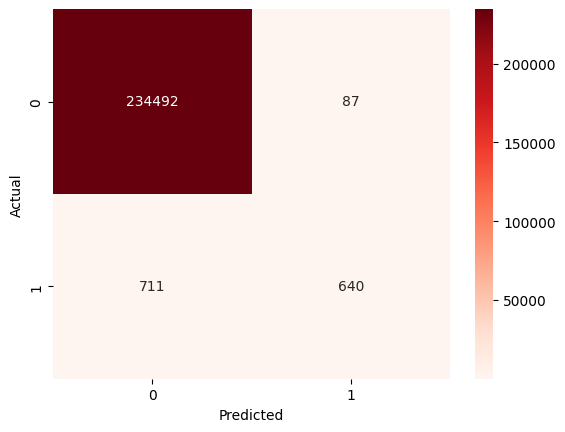

In [35]:
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

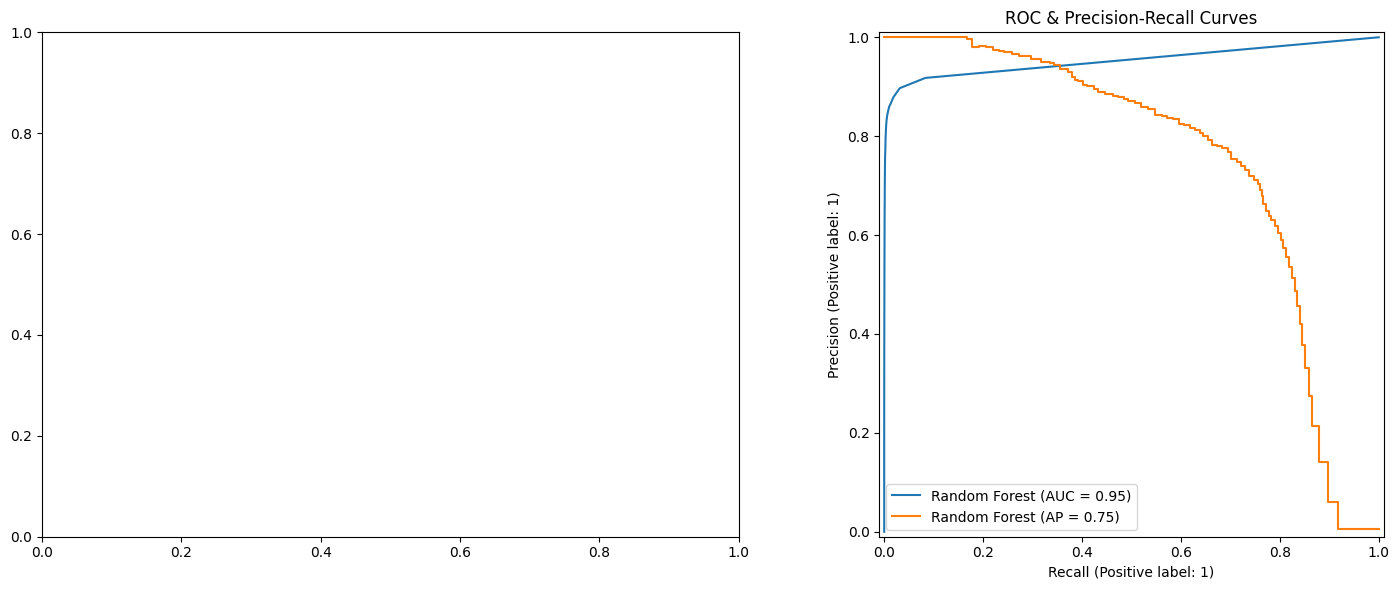

In [36]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax2, name='Random Forest')
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, name='Random Forest')
ax2.set_title('ROC & Precision-Recall Curves')
plt.tight_layout()
plt.show()

ROC AUC = 0.95 указывает на отличную способность модели различать между классами.

Average Precision (AP) = 0.75 подтверждает умеренное качество в обнаружении мошенничества (класс 1), несмотря на неидеальный recall.

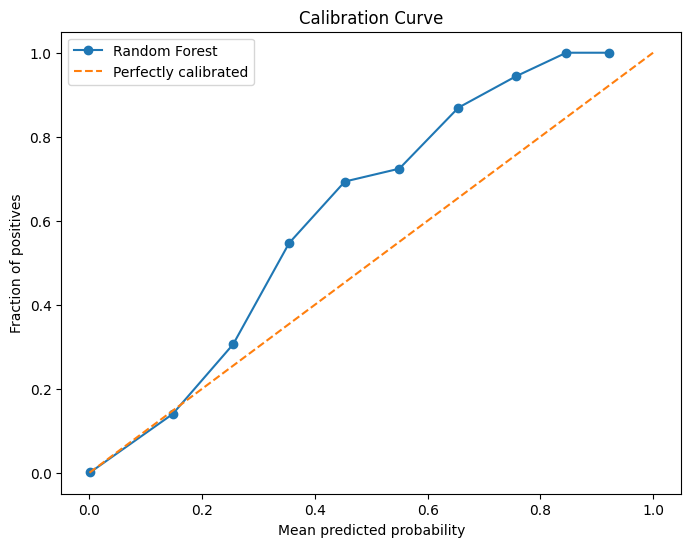

In [37]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Подбор гиперпараметров

param_grid задает набор гиперпараметров для поиска оптимальной конфигурации модели (random forest):

* Количество деревьев (n_estimators)

* Глубина деревьев (max_depth)

* Минимальное количество образцов для разделения (min_samples_split)

* Минимальное количество образцов в листьях (min_samples_leaf)

* Количество признаков, используемых для каждого дерева (max_features)

* Использование бутстрэппинга (bootstrap)

In [16]:
param_grid = {'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False],
}
print("Параметры для поиска:")
print(param_grid)

Параметры для поиска:
{'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20, 30], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__max_features': ['sqrt', 'log2', None], 'classifier__bootstrap': [True, False]}


In [ ]:
grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)
print("Начало поиска параметров...")
grid_search.fit(X_train, y_train)
print("Поиск параметров завершен!")

Начало поиска параметров...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [ ]:
print("Лучшие параметры:")
print(grid_search.best_params_)
print("Лучший score (F1):")
print(grid_search.best_score_)

In [ ]:
import joblib
model_1 = grid_search.best_estimator_
joblib.dump(model_1, 'hyper_model.pkl')
print("Лучшая модель сохранена как 'hyper_model.pkl'")

In [ ]:
y_pred_1 = model_1.predict(X_test)
y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]

# Оценка параметров втрой модели


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_1))

In [ ]:
roc_auc_1 = roc_auc_score(y_test_1, y_pred_proba_1)
RocCurveDisplay.from_estimator(model_1, X_test, y_test, ax=ax2, name='Random Forest'),
PrecisionRecallDisplay.from_estimator(model_1, X_test, y_test, ax=ax2, name='Random Forest')
ax2.set_title('ROC & Precision-Recall Curves')
plt.tight_layout()
plt.show()

In [ ]:
test_predict = model.predict(test_transaction)

In [ ]:
df = pd.DataFrame(test_predict, columns = ['prediction'])

In [ ]:
df.to_csv('gdrive/My Drive/teta_ml_1/submission_1.csv', index=True, index_label='index')